In [19]:
import numpy as np
import os
import torch
import torchvision.models as models
from torch.utils.data import TensorDataset, DataLoader

from src.utils.consts import (HDD_VIDEO_PATH, HDD_ALL_FRAMES_ALL_VIDS_PATH,
                         HDD_TRAIN_SIDS, HDD_TEST_SIDS, MAP_LBL_TO_CLS_LYR_0)
from src.utils.data_prep_util import extract_frames, get_saved_index_pkl, get_sequence_wise_fvecs_and_labels
from src.utils.cnn_lstm_utils import get_cnn_codes_for_frames_tt
from src.utils.exp_util import plot_conf_mat_heat_map
model = models.resnet18(pretrained=True)
import subprocess

In [8]:
for session_id in HDD_TRAIN_SIDS:
    frames_fvecs_lst = []
    files = os.listdir(HDD_VIDEO_PATH.format(session_id))
    all_frames = extract_frames(HDD_VIDEO_PATH.format(session_id)+"/"+files[0])
    num_frames = all_frames.shape[0]
    for start in range(0, num_frames, 40):
        end = min(start+40, num_frames)
        frames_vecs = get_cnn_codes_for_frames_tt(model, all_frames[start:end])
        frames_fvecs_lst.append(frames_vecs)

In [9]:
frames_vecs.shape

torch.Size([3, 512, 1, 1])

In [10]:
len(frames_fvecs_lst)

34

In [17]:
frames_fvecs_lst[0].shape

torch.Size([40, 512, 1, 1])

In [32]:
frames_lst = []
for i in range(3):
    print(frames_vecs[i].shape[0])
    frames_lst.append(frames_vecs[i].view(512).numpy())
    
frames_fvecs_lst[0][0].shape
len(frames_lst)


def get_length(filename):
    def get_sec(time_str):
        h, m, s = time_str.split(b':')
        return int(h) * 3600 + int(m) * 60 + float(s)

    result = subprocess.Popen(["ffprobe", filename],
                              stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
    time_string = [x for x in result.stdout.readlines() if b"Duration" in x][0]
    return get_sec(time_string.split(b",")[0].split(b": ")[-1])



512
512
512


In [8]:
for session_id in HDD_TRAIN_SIDS:
    files = os.listdir(HDD_VIDEO_PATH.format(session_id))
    filename = HDD_VIDEO_PATH.format(session_id)+"/"+files[0]
    print(get_length(filename))

441.034


In [13]:
def get_length(filename):
    result = subprocess.run(["ffprobe", "-v", "error", "-show_entries",
                             "format=duration", "-of", "default=noprint_wrappers=1:nokey=1", filename],
        stdout=subprocess.PIPE,
        stderr=subprocess.STDOUT)
    return float(result.stdout)
for session_id in HDD_TRAIN_SIDS:
    files = os.listdir(HDD_VIDEO_PATH.format(session_id))
    filename = HDD_VIDEO_PATH.format(session_id)+"/"+files[0]
    print(get_length(filename))

441.034


In [15]:
si = get_saved_index_pkl()

In [38]:
events_pd = si["events_pd"]
events_pd["layer"].unique()

array([0, 1, 2, 3, 4, 5, 6])

In [41]:
session_rows = events_pd[(events_pd["session_id"] == "201702271123") & (events_pd["layer"] == 2)]
session_rows

,layer,event_type,session_id,start,end
18732,2,32,201702271123,0,441034


In [40]:
fps = "3/1"
for row in session_rows.iterrows():
    print(row[0])
    print(row[1]["start"]/1000 * 3)

1207
332.841
1208
638.991
1209
1073.961
1210
1153.347
4568
167.841
4569
254.66699999999997
4570
461.25
4571
573.207
4572
713.7239999999999
4573
805.767
4574
880.7640000000001
4575
986.337
4576
1116.195
4577
1264.815
8953
1037.043
10839
67.71000000000001
11857
960.261
11858
1195.3980000000001
11859
1319.5230000000001


In [1]:
from src.utils.data_prep_util import get_sequence_wise_fvecs_and_labels
from src.utils.exp_util import get_map_of_unique_classes_for_layer
from src.utils.consts import HDD_TRAIN_SIDS, HDD_TEST_SIDS
import numpy as np

In [2]:
num_unq_cls, map_lbl_to_cls, map_cls_to_lbl = get_map_of_unique_classes_for_layer(
        HDD_TRAIN_SIDS, 0)
fvecs, labels = get_sequence_wise_fvecs_and_labels("201709210940", 0, 90, map_lbl_to_cls)
fvecs.shape, labels.shape

((120,), (120,))

In [3]:
print(type(labels[2]))
from torch.utils.data import TensorDataset, DataLoader
import torch

<class 'numpy.ndarray'>


In [4]:

fvecs_t = torch.stack([torch.from_numpy(fvec) for fvec in fvecs[:-1]])
labels_t = torch.stack([torch.from_numpy(label) for label in labels[:-1]])
print(torch.unique(labels_t))

train_data = TensorDataset(fvecs_t, labels_t)

tensor([0, 1, 2, 3, 5, 6, 7, 9])


In [5]:
train_loader = DataLoader(dataset=train_data, batch_size=40, shuffle=False)

In [10]:
for x, y in train_loader:
    print (x.shape, y.shape)

torch.Size([40, 90, 512]) torch.Size([40, 90])
torch.Size([40, 90, 512]) torch.Size([40, 90])
torch.Size([39, 90, 512]) torch.Size([39, 90])


In [9]:
print(num_unq_cls)
print(map_lbl_to_cls)
print(map_cls_to_lbl)

12
{0.0: 0, 1.0: 1, 2.0: 2, 3.0: 3, 4.0: 4, 5.0: 5, 6.0: 6, 7.0: 7, 8.0: 8, 10.0: 9, 11.0: 10, 12.0: 11}
{0: 0.0, 1: 1.0, 2: 2.0, 3: 3.0, 4: 4.0, 5: 5.0, 6: 6.0, 7: 7.0, 8: 8.0, 9: 10.0, 10: 11.0, 11: 12.0}


In [11]:
ts_ul_cnt, ts_ul_map, ts_cl_map = get_map_of_unique_classes_for_layer(HDD_TEST_SIDS, 0)

In [13]:
ts_ul_cnt, ts_ul_map, ts_cl_map

(12,
 {0.0: 0,
  1.0: 1,
  2.0: 2,
  3.0: 3,
  4.0: 4,
  5.0: 5,
  6.0: 6,
  7.0: 7,
  8.0: 8,
  10.0: 9,
  11.0: 10,
  12.0: 11},
 {0: 0.0,
  1: 1.0,
  2: 2.0,
  3: 3.0,
  4: 4.0,
  5: 5.0,
  6: 6.0,
  7: 7.0,
  8: 8.0,
  9: 10.0,
  10: 11.0,
  11: 12.0})

In [20]:
import torch
output = torch.randn(3, 4, 5)
train_clss = torch.randn(3, 4)
print(output.view(-1, 5).shape, train_clss.view(-1).shape)

torch.Size([12, 5]) torch.Size([12])


In [22]:
print(output)
print(output.view(-1, 5))

tensor([[[-0.8202, -0.7720,  0.5749,  0.9233, -1.0970],
         [-0.4713, -1.2166, -1.8238, -0.7495, -0.3654],
         [-1.1689, -0.1251, -1.6567,  0.0965,  1.2511],
         [ 2.0249, -0.7272,  0.1559,  1.2814,  0.6847]],

        [[ 0.1606, -2.6523,  0.1823,  0.5514, -0.2323],
         [ 1.0380, -1.5724,  0.5753,  1.6914, -0.8425],
         [ 0.9869,  0.7831, -0.8116, -0.0644, -0.3113],
         [ 0.3491, -0.9055, -0.4162, -0.9037, -0.2829]],

        [[-0.0191,  0.4710, -0.3959,  2.1329, -0.7635],
         [-1.5661,  0.8526,  0.5746, -0.1830,  1.4722],
         [-0.8471,  1.1734, -0.9500,  0.9141, -0.1215],
         [-0.1937, -1.5870, -0.4267,  1.0605,  0.6665]]])
tensor([[-0.8202, -0.7720,  0.5749,  0.9233, -1.0970],
        [-0.4713, -1.2166, -1.8238, -0.7495, -0.3654],
        [-1.1689, -0.1251, -1.6567,  0.0965,  1.2511],
        [ 2.0249, -0.7272,  0.1559,  1.2814,  0.6847],
        [ 0.1606, -2.6523,  0.1823,  0.5514, -0.2323],
        [ 1.0380, -1.5724,  0.5753,  1.6914, -0

Predicted      0      1      2      3      4
Actual                                      
0          18.68  18.91  21.41  21.87  19.13
1          16.07  21.17  19.90  21.94  20.92
2          19.54  23.14  18.77  19.28  19.28
3          23.78  21.08  20.00  16.76  18.38
4          21.46  19.02  18.78  21.22  19.51


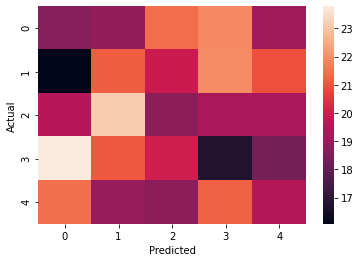

In [6]:
y_true = np.random.randint(0, 5, 2000)
y_pred = np.random.randint(0, 5, 2000)
plot_conf_mat_heat_map(y_true, y_pred)

In [41]:
for i in range(2):
    fvecs, fclss = get_sequence_wise_fvecs_and_labels("201702271017", 0, 3600, MAP_LBL_TO_CLS_LYR_0)
    print(fvecs.shape)
    def custom_dl():
        for fvec, fcls in zip(fvecs, fclss):
            fvec, fcls = torch.from_numpy(fvec).unsqueeze(0), torch.from_numpy(fcls).unsqueeze(0)
            #print(fvec.size(), fcls.size())
            yield fvec, fcls
            
    dl = custom_dl()
    print(type(dl))
    for fvec, fcls in dl:
        print(fvec.shape, fcls.shape)

(3,)
<class 'generator'>
torch.Size([1, 3600, 512]) torch.Size([1, 3600])
torch.Size([1, 3600, 512]) torch.Size([1, 3600])
torch.Size([1, 2340, 512]) torch.Size([1, 2340])
(3,)
<class 'generator'>
torch.Size([1, 3600, 512]) torch.Size([1, 3600])
torch.Size([1, 3600, 512]) torch.Size([1, 3600])
torch.Size([1, 2340, 512]) torch.Size([1, 2340])


In [17]:
fvecs = torch.stack([torch.from_numpy(fvec) for fvec in fvecs[:-1]])
fvecs.size()

torch.Size([2, 3600, 512])